##  Notebook 05 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Abordagem 5: CNN - Convolutional Neural Network como Regressor - 5 Classes

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import RobustScaler
import seaborn as sn

## Reading Measurement Data and Preprocessing

In [ ]:
# Option a) local file contains a small subset of the entire dataset
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [ ]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

**PRÉ-TRATAMENTO DOS SINAIS**

Separação das duas sequências de aquisição de dados

In [ ]:
data0D_A = data0D.iloc[0:int(len(data0D)/2)]
data0D_B = data0D.iloc[int(len(data0D)/2):]
data0E_A = data0E.iloc[0:int(len(data0E)/2)]
data0E_B = data0E.iloc[int(len(data0E)/2):]
data1D_A = data1D.iloc[0:int(len(data1D)/2)]
data1D_B = data1D.iloc[int(len(data1D)/2):]
data1E_A = data1E.iloc[0:int(len(data1E)/2)]
data1E_B = data1E.iloc[int(len(data1E)/2):]
data2D_A = data2D.iloc[0:int(len(data2D)/2)]
data2D_B = data2D.iloc[int(len(data2D)/2):]
data2E_A = data2E.iloc[0:int(len(data2E)/2)]
data2E_B = data2E.iloc[int(len(data2E)/2):]
data3D_A = data3D.iloc[0:int(len(data3D)/2)]
data3D_B = data3D.iloc[int(len(data3D)/2):]
data3E_A = data3E.iloc[0:int(len(data3E)/2)]
data3E_B = data3E.iloc[int(len(data3E)/2):]
data4D_A = data4D.iloc[0:int(len(data4D)/2)]
data4D_B = data4D.iloc[int(len(data4D)/2):]
data4E_A = data4E.iloc[0:int(len(data4E)/2)]
data4E_B = data4E.iloc[int(len(data4E)/2):]

Descarte das amostras iniciais e finais

In [ ]:
skip = 100000
data0D_A = data0D_A.iloc[skip:-skip,:]
data0D_B = data0D_B.iloc[skip:-skip,:]
data0E_A = data0E_A.iloc[skip:-skip,:]
data0E_B = data0E_B.iloc[skip:-skip,:]
data1D_A = data1D_A.iloc[skip:-skip,:]
data1D_B = data1D_B.iloc[skip:-skip,:]
data1E_A = data1E_A.iloc[skip:-skip,:]
data1E_B = data1E_B.iloc[skip:-skip,:]
data2D_A = data2D_A.iloc[skip:-skip,:]
data2D_B = data2D_B.iloc[skip:-skip,:]
data2E_A = data2E_A.iloc[skip:-skip,:]
data2E_B = data2E_B.iloc[skip:-skip,:]
data3D_A = data3D_A.iloc[skip:-skip,:]
data3D_B = data3D_B.iloc[skip:-skip,:]
data3E_A = data3E_A.iloc[skip:-skip,:]
data3E_B = data3E_B.iloc[skip:-skip,:]
data4D_A = data4D_A.iloc[skip:-skip,:]
data4D_B = data4D_B.iloc[skip:-skip,:]
data4E_A = data4E_A.iloc[skip:-skip,:]
data4E_B = data4E_B.iloc[skip:-skip,:]

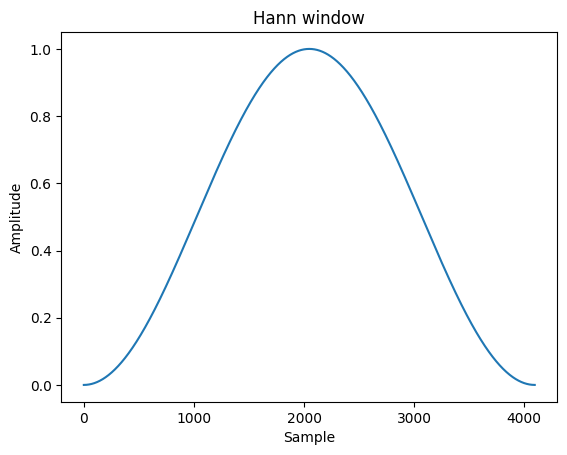

In [ ]:
window = np.hanning(4096)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

Normalização pelo quadrado da velocidade

In [ ]:
def normaliza_vibracao(basededados, sensor, quad=True):
  if quad:
    basededados[sensor] = basededados[sensor]/np.square(basededados['Measured_RPM'])
  else:
    basededados[sensor] = basededados[sensor]/basededados['Measured_RPM']
  return basededados

Função para segmentar a série temporal

In [ ]:
labels = {'Balanced' : 0.0, 'Unbalanced_LowLow' : 45.9, 'Unbalanced_Low': 60.7, 'Unbalanced_High': 75.5, 'Unbalanced_HighHigh': 152.1}

samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

Dividindo a série temporal dos dados do sensor **"Vibration_1"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Vibration_1'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_1=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_1_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Vibration_2"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Vibration_2'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_2=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_2_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Vibration_3"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Vibration_3'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_3=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_3_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Measured_RPM"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Measured_RPM'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Measured_RPM=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Measured_RPM_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Now the dataset for training X contains 32142 samples with 4096 values each as well as the associated label information y with 32142 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [ ]:
print(X_Vibration_1.shape, y.shape, X_Vibration_1_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


In [ ]:
print(X_Vibration_2.shape, y.shape, X_Vibration_2_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


In [ ]:
print(X_Vibration_3.shape, y.shape, X_Vibration_3_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


In [ ]:
print(X_Measured_RPM.shape, y.shape, X_Measured_RPM_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


**Janelamento dos sinais de vibração** (Posicionado aqui para não gerar estouro de RAM)

In [ ]:
def janelamentoHanning(basededados, window):
  janela_hanning = np.hanning(window)
  basededados = basededados*janela_hanning
  return basededados

In [ ]:
X_Vibration_1_jan = janelamentoHanning(X_Vibration_1, 4096)
X_Vibration_1_val_jan = janelamentoHanning(X_Vibration_1_val, 4096)
X_Vibration_2_jan = janelamentoHanning(X_Vibration_2, 4096)
X_Vibration_2_val_jan = janelamentoHanning(X_Vibration_2_val, 4096)
X_Vibration_3_jan = janelamentoHanning(X_Vibration_3, 4096)
X_Vibration_3_val_jan = janelamentoHanning(X_Vibration_3_val, 4096)

In [ ]:
X_Vibration_1_jan.shape

(31736, 4096)

Calculando as estatísticas da velocidade

In [ ]:
X_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)
X_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)
X_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)
X_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)

In [ ]:
X_Measured_RPM_mean.shape

(31736, 1)

**Função para cálculo da FFT**

In [ ]:
def calcula_fft(basededados, window, freq_inicio, freq_fim):
  X_fft = np.abs(np.fft.rfft(basededados, axis=1))[:,:int(window/2)]
  return X_fft[:, freq_inicio:freq_fim]

**Extrair o Módulo da FFT do sinal**

In [ ]:
freq_inicio = 0 #Hz
freq_fim = 4096 #Hz

X_Vibration_1_fft = calcula_fft(X_Vibration_1_jan, 4096, freq_inicio, freq_fim)
X_Vibration_1_val_fft = calcula_fft(X_Vibration_1_val_jan, 4096, freq_inicio, freq_fim)
X_Vibration_2_fft = calcula_fft(X_Vibration_2_jan, 4096, freq_inicio, freq_fim)
X_Vibration_2_val_fft = calcula_fft(X_Vibration_2_val_jan, 4096, freq_inicio, freq_fim)
X_Vibration_3_fft = calcula_fft(X_Vibration_3_jan, 4096, freq_inicio, freq_fim)
X_Vibration_3_val_fft = calcula_fft(X_Vibration_3_val_jan, 4096, freq_inicio, freq_fim)

## **Encaixar no código**

Definir quais sinais serão utilizados de entrada para o modelo de Machine Learning

In [ ]:
#X = np.concatenate(( X_Measured_RPM_mean, X_Vibration_1_fft), axis=1) # X_Vibration_2_fft, X_Vibration_3_fft, X_Measured_RPM_mean), axis=1)
#X_val = np.concatenate((X_Measured_RPM_val_mean, X_Vibration_1_val_fft), axis=1) # X_Vibration_2_val_fft, X_Vibration_3_val_fft, X_Measured_RPM_val_mean), axis=1)

In [ ]:
X = X_Vibration_1_fft
X_val = X_Vibration_1_val_fft

## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048, 1) (28562,) (3174, 2048, 1) (3174,) (7932, 2048, 1) (7932,)


**Escalonamento**

In [ ]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train[:,:,0])
X_train = scaler.transform(X_train[:,:,0])
X_test = scaler.transform(X_test[:,:,0])
X_val = scaler.transform(X_val[:,:,0])

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048) (28562,) (3174, 2048) (3174,) (7932, 2048) (7932,)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 1028
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 5 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 100 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*20,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #segunda camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #terceira camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quarta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quinta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'linear')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'mean_absolute_error',
                       metrics = ['MeanAbsoluteError'])

    history = classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint])

    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

In [ ]:
nMaxConvLayers = 5

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1028)           │    20,972,228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,204,705 (96.15 MB)

 Trainable params: 25,204,665 (96.15 MB)

 Non-trainable params: 40 (160.00 B)

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - MeanAbsoluteError: 20.8708 - loss: 20.8708
Epoch 1: val_loss improved from inf to 6.87682, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - MeanAbsoluteError: 20.8545 - loss: 20.8545 - val_MeanAbsoluteError: 6.8768 - val_loss: 6.8768
Epoch 2/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 8.0867 - loss: 8.0867
Epoch 2: val_loss improved from 6.87682 to 5.59299, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 8.0855 - loss: 8.0855 - val_MeanAbsoluteError: 5.5930 - val_loss: 5.5930
Epoch 3/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.9623 - loss: 6.9623
Epoch 3: val_loss improved from 5.59299 to 4.94809, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 6.9607 - loss: 6.9607 - val_MeanAbsoluteError: 4.9481 - val_loss: 4.9481
Epoch 4/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.3196 - loss: 6.3196
Epoch 4: val_loss improved from 4.94809 to 4.69306, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 6.3204 - loss: 6.3204 - val_MeanAbsoluteError: 4.6931 - val_loss: 4.6931
Epoch 5/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.3447 - loss: 6.3447
Epoch 5: val_loss did not improve from 4.69306
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 6.3455 - loss: 6.3455 - val_MeanAbsoluteError: 7.6977 - val_loss: 7.6977
Epoch 6/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.0712 - loss: 6.0712
Epoch 6: val_loss improved from 4.69306 to 2.89594, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 6.0698 - loss: 6.0698 - val_MeanAbsoluteError: 2.8959 - val_loss: 2.8959
Epoch 7/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.1215 - loss: 6.1215
Epoch 7: val_loss did not improve from 2.89594
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 6.1221 - loss: 6.1221 - val_MeanAbsoluteError: 2.9492 - val_loss: 2.9492
Epoch 8/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.8208 - loss: 4.8208
Epoch 8: val_loss did not improve from 2.89594
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.8219 - loss: 4.8219 - val_MeanAbsoluteError: 5.2019 - val_loss: 5.2019
Epoch 9/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.4357 - loss: 5.4357
Epoch 9: val_loss did not improve from 2.89594
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 5.4348 - loss: 5.4348 - val_MeanAbsoluteError: 7.9714 - val_loss: 7.9714
Epoch 10/100
445/447 ━━━━━━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 6.1802 - loss: 6.1802 - val_MeanAbsoluteError: 2.7423 - val_loss: 2.7423
Epoch 11/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.8539 - loss: 4.8539
Epoch 11: val_loss did not improve from 2.74234
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.8544 - loss: 4.8544 - val_MeanAbsoluteError: 3.4791 - val_loss: 3.4791
Epoch 12/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.2083 - loss: 5.2083
Epoch 12: val_loss improved from 2.74234 to 2.27883, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 5.2093 - loss: 5.2093 - val_MeanAbsoluteError: 2.2788 - val_loss: 2.2788
Epoch 13/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.0688 - loss: 5.0688
Epoch 13: val_loss did not improve from 2.27883
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 5.0665 - loss: 5.0665 - val_MeanAbsoluteError: 2.5049 - val_loss: 2.5049
Epoch 14/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.7595 - loss: 4.7595
Epoch 14: val_loss did not improve from 2.27883
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.7597 - loss: 4.7597 - val_MeanAbsoluteError: 5.6795 - val_loss: 5.6795
Epoch 15/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.5233 - loss: 4.5233
Epoch 15: val_loss did not improve from 2.27883
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.5258 - loss: 4.5258 - val_MeanAbsoluteError: 4.4030 - val_loss: 4.4030
Epoch 16/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 4.6082 - loss: 4.6082 - val_MeanAbsoluteError: 2.0542 - val_loss: 2.0542
Epoch 17/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.4129 - loss: 4.4129
Epoch 17: val_loss did not improve from 2.05423
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.4127 - loss: 4.4127 - val_MeanAbsoluteError: 3.1139 - val_loss: 3.1139
Epoch 18/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.9283 - loss: 3.9283
Epoch 18: val_loss did not improve from 2.05423
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.9293 - loss: 3.9293 - val_MeanAbsoluteError: 4.6925 - val_loss: 4.6925
Epoch 19/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.1639 - loss: 4.1639
Epoch 19: val_loss did not improve from 2.05423
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.1653 - loss: 4.1653 - val_MeanAbsoluteError: 3.4540 - val_loss: 3.4540
Epoch 20/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 3.5292 - loss: 3.5292 - val_MeanAbsoluteError: 1.8922 - val_loss: 1.8922
Epoch 32/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.2636 - loss: 3.2636
Epoch 32: val_loss improved from 1.89218 to 1.75232, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 3.2634 - loss: 3.2634 - val_MeanAbsoluteError: 1.7523 - val_loss: 1.7523
Epoch 33/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.5104 - loss: 3.5104
Epoch 33: val_loss did not improve from 1.75232
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.5100 - loss: 3.5100 - val_MeanAbsoluteError: 4.3538 - val_loss: 4.3538
Epoch 34/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.8320 - loss: 3.8320
Epoch 34: val_loss did not improve from 1.75232
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.8299 - loss: 3.8299 - val_MeanAbsoluteError: 2.8507 - val_loss: 2.8507
Epoch 35/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.3496 - loss: 3.3496
Epoch 35: val_loss did not improve from 1.75232
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.3495 - loss: 3.3495 - val_MeanAbsoluteError: 3.1313 - val_loss: 3.1313
Epoch 36/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 3.1493 - loss: 3.1493 - val_MeanAbsoluteError: 1.3680 - val_loss: 1.3680
Epoch 39/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.0393 - loss: 3.0393
Epoch 39: val_loss did not improve from 1.36801
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.0394 - loss: 3.0394 - val_MeanAbsoluteError: 1.5504 - val_loss: 1.5504
Epoch 40/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.3259 - loss: 3.3259
Epoch 40: val_loss did not improve from 1.36801
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.3257 - loss: 3.3257 - val_MeanAbsoluteError: 2.1892 - val_loss: 2.1892
Epoch 41/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.8500 - loss: 2.8500
Epoch 41: val_loss did not improve from 1.36801
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.8509 - loss: 2.8509 - val_MeanAbsoluteError: 2.5739 - val_loss: 2.5739
Epoch 42/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.1181 - loss: 2.1181 - val_MeanAbsoluteError: 1.2345 - val_loss: 1.2345
Epoch 68/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.2184 - loss: 2.2184
Epoch 68: val_loss did not improve from 1.23451
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.2180 - loss: 2.2180 - val_MeanAbsoluteError: 1.8485 - val_loss: 1.8485
Epoch 69/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0762 - loss: 2.0762
Epoch 69: val_loss improved from 1.23451 to 1.12911, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.0769 - loss: 2.0769 - val_MeanAbsoluteError: 1.1291 - val_loss: 1.1291
Epoch 70/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0280 - loss: 2.0280
Epoch 70: val_loss did not improve from 1.12911
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.0286 - loss: 2.0286 - val_MeanAbsoluteError: 1.2148 - val_loss: 1.2148
Epoch 71/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0867 - loss: 2.0867
Epoch 71: val_loss did not improve from 1.12911
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.0859 - loss: 2.0859 - val_MeanAbsoluteError: 3.0638 - val_loss: 3.0638
Epoch 72/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.1663 - loss: 2.1663
Epoch 72: val_loss improved from 1.12911 to 1.07394, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.1650 - loss: 2.1650 - val_MeanAbsoluteError: 1.0739 - val_loss: 1.0739
Epoch 73/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.1776 - loss: 2.1776
Epoch 73: val_loss did not improve from 1.07394
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.1776 - loss: 2.1776 - val_MeanAbsoluteError: 1.1455 - val_loss: 1.1455
Epoch 74/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0954 - loss: 2.0954
Epoch 74: val_loss did not improve from 1.07394
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.0958 - loss: 2.0958 - val_MeanAbsoluteError: 1.5946 - val_loss: 1.5946
Epoch 75/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.1148 - loss: 2.1148
Epoch 75: val_loss did not improve from 1.07394
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.1142 - loss: 2.1142 - val_MeanAbsoluteError: 1.8419 - val_loss: 1.8419
Epoch 76/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.7255 - loss: 1.7255 - val_MeanAbsoluteError: 0.9622 - val_loss: 0.9622
Epoch 84/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7573 - loss: 1.7573
Epoch 84: val_loss did not improve from 0.96222
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.7575 - loss: 1.7575 - val_MeanAbsoluteError: 1.2395 - val_loss: 1.2395
Epoch 85/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.8252 - loss: 1.8252
Epoch 85: val_loss did not improve from 0.96222
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.8255 - loss: 1.8255 - val_MeanAbsoluteError: 1.0429 - val_loss: 1.0429
Epoch 86/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.8795 - loss: 1.8795
Epoch 86: val_loss did not improve from 0.96222
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.8783 - loss: 1.8783 - val_MeanAbsoluteError: 1.1311 - val_loss: 1.1311
Epoch 87/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.7659 - loss: 1.7659 - val_MeanAbsoluteError: 0.9360 - val_loss: 0.9360
Epoch 89/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.6346 - loss: 1.6346
Epoch 89: val_loss did not improve from 0.93605
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.6345 - loss: 1.6345 - val_MeanAbsoluteError: 1.1019 - val_loss: 1.1019
Epoch 90/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7451 - loss: 1.7451
Epoch 90: val_loss did not improve from 0.93605
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.7448 - loss: 1.7448 - val_MeanAbsoluteError: 1.6705 - val_loss: 1.6705
Epoch 91/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5675 - loss: 1.5675
Epoch 91: val_loss did not improve from 0.93605
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.5674 - loss: 1.5674 - val_MeanAbsoluteError: 1.0255 - val_loss: 1.0255
Epoch 92/100
445/447 ━━━

248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.5452 - mean_absolute_error: 4.5452


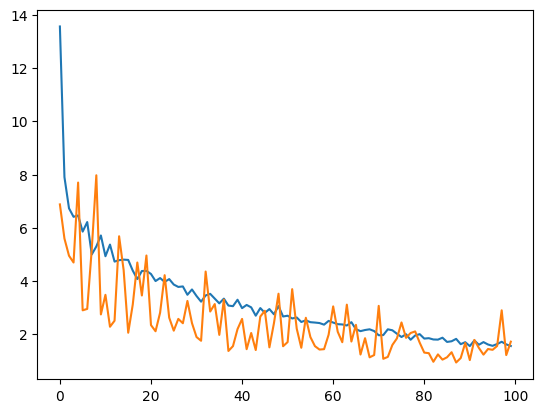

0
1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1028)           │    20,807,748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1028)           │             

 Total params: 25,044,425 (95.54 MB)

 Trainable params: 25,044,305 (95.54 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - MeanAbsoluteError: 21.9725 - loss: 21.9725
Epoch 1: val_loss improved from inf to 5.40423, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - MeanAbsoluteError: 21.9560 - loss: 21.9560 - val_MeanAbsoluteError: 5.4042 - val_loss: 5.4042
Epoch 2/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 9.0494 - loss: 9.0494
Epoch 2: val_loss did not improve from 5.40423
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 9.0435 - loss: 9.0435 - val_MeanAbsoluteError: 6.9971 - val_loss: 6.9971
Epoch 3/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.4188 - loss: 6.4188
Epoch 3: val_loss improved from 5.40423 to 4.35496, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 6.4162 - loss: 6.4162 - val_MeanAbsoluteError: 4.3550 - val_loss: 4.3550
Epoch 4/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.7837 - loss: 5.7837
Epoch 4: val_loss improved from 4.35496 to 2.69002, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 5.7810 - loss: 5.7810 - val_MeanAbsoluteError: 2.6900 - val_loss: 2.6900
Epoch 5/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.7969 - loss: 4.7969
Epoch 5: val_loss improved from 2.69002 to 2.54529, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 4.7965 - loss: 4.7965 - val_MeanAbsoluteError: 2.5453 - val_loss: 2.5453
Epoch 6/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.0987 - loss: 4.0987
Epoch 6: val_loss did not improve from 2.54529
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 4.0988 - loss: 4.0988 - val_MeanAbsoluteError: 3.1215 - val_loss: 3.1215
Epoch 7/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.8318 - loss: 3.8318 
Epoch 7: val_loss did not improve from 2.54529
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 3.8328 - loss: 3.8328 - val_MeanAbsoluteError: 3.3480 - val_loss: 3.3480
Epoch 8/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.4501 - loss: 3.4501
Epoch 8: val_loss did not improve from 2.54529
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 3.4498 - loss: 3.4498 - val_MeanAbsoluteError: 3.0109 - val_loss: 3.0109
Epoch 9/100
444/447 ━━━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 3.2190 - loss: 3.2190 - val_MeanAbsoluteError: 2.2121 - val_loss: 2.2121
Epoch 10/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.0273 - loss: 3.0273
Epoch 10: val_loss did not improve from 2.21211
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 3.0250 - loss: 3.0250 - val_MeanAbsoluteError: 2.9642 - val_loss: 2.9642
Epoch 11/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.7453 - loss: 2.7453
Epoch 11: val_loss improved from 2.21211 to 1.65892, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.7446 - loss: 2.7446 - val_MeanAbsoluteError: 1.6589 - val_loss: 1.6589
Epoch 12/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 2.5089 - loss: 2.5089
Epoch 12: val_loss did not improve from 1.65892
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.5076 - loss: 2.5076 - val_MeanAbsoluteError: 2.5215 - val_loss: 2.5215
Epoch 13/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.5639 - loss: 2.5639
Epoch 13: val_loss improved from 1.65892 to 1.50919, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.5642 - loss: 2.5642 - val_MeanAbsoluteError: 1.5092 - val_loss: 1.5092
Epoch 14/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 2.4321 - loss: 2.4321
Epoch 14: val_loss did not improve from 1.50919
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.4314 - loss: 2.4314 - val_MeanAbsoluteError: 1.8763 - val_loss: 1.8763
Epoch 15/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 2.4269 - loss: 2.4269
Epoch 15: val_loss did not improve from 1.50919
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.4257 - loss: 2.4257 - val_MeanAbsoluteError: 2.9290 - val_loss: 2.9290
Epoch 16/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0093 - loss: 2.0093
Epoch 16: val_loss did not improve from 1.50919
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.0095 - loss: 2.0095 - val_MeanAbsoluteError: 2.0936 - val_loss: 2.0936
Epoch 17/100
445/44

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.8812 - loss: 1.8812 - val_MeanAbsoluteError: 1.2413 - val_loss: 1.2413
Epoch 22/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.4404 - loss: 1.4404
Epoch 22: val_loss did not improve from 1.24126
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.4407 - loss: 1.4407 - val_MeanAbsoluteError: 1.4689 - val_loss: 1.4689
Epoch 23/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 1.7559 - loss: 1.7559
Epoch 23: val_loss did not improve from 1.24126
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.7561 - loss: 1.7561 - val_MeanAbsoluteError: 1.9958 - val_loss: 1.9958
Epoch 24/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7411 - loss: 1.7411
Epoch 24: val_loss improved from 1.24126 to 1.19496, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.7401 - loss: 1.7401 - val_MeanAbsoluteError: 1.1950 - val_loss: 1.1950
Epoch 25/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5049 - loss: 1.5049
Epoch 25: val_loss improved from 1.19496 to 1.04445, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.5055 - loss: 1.5055 - val_MeanAbsoluteError: 1.0444 - val_loss: 1.0444
Epoch 26/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.4690 - loss: 1.4690
Epoch 26: val_loss did not improve from 1.04445
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.4696 - loss: 1.4696 - val_MeanAbsoluteError: 2.0476 - val_loss: 2.0476
Epoch 27/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.4591 - loss: 1.4591
Epoch 27: val_loss improved from 1.04445 to 0.97852, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.4595 - loss: 1.4595 - val_MeanAbsoluteError: 0.9785 - val_loss: 0.9785
Epoch 28/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3924 - loss: 1.3924
Epoch 28: val_loss did not improve from 0.97852
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.3924 - loss: 1.3924 - val_MeanAbsoluteError: 1.2509 - val_loss: 1.2509
Epoch 29/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3815 - loss: 1.3815
Epoch 29: val_loss did not improve from 0.97852
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.3824 - loss: 1.3824 - val_MeanAbsoluteError: 1.1564 - val_loss: 1.1564
Epoch 30/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3974 - loss: 1.3974
Epoch 30: val_loss did not improve from 0.97852
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.3972 - loss: 1.3972 - val_MeanAbsoluteError: 1.2412 - val_loss: 1.2412
Epoch 31/100
445/447 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.2953 - loss: 1.2953 - val_MeanAbsoluteError: 0.7689 - val_loss: 0.7689
Epoch 38/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.1081 - loss: 1.1081
Epoch 38: val_loss did not improve from 0.76890
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.1088 - loss: 1.1088 - val_MeanAbsoluteError: 2.7124 - val_loss: 2.7124
Epoch 39/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 1.2386 - loss: 1.2386
Epoch 39: val_loss did not improve from 0.76890
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.2399 - loss: 1.2399 - val_MeanAbsoluteError: 0.8685 - val_loss: 0.8685
Epoch 40/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.2013 - loss: 1.2013
Epoch 40: val_loss did not improve from 0.76890
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.2012 - loss: 1.2012 - val_MeanAbsoluteError: 0.7940 - val_loss: 0.7940
Epoch 41/100
445/447

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.0347 - loss: 1.0347 - val_MeanAbsoluteError: 0.7616 - val_loss: 0.7616
Epoch 50/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsoluteError: 1.0433 - loss: 1.0433
Epoch 50: val_loss did not improve from 0.76162
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0434 - loss: 1.0434 - val_MeanAbsoluteError: 1.4420 - val_loss: 1.4420
Epoch 51/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9738 - loss: 0.9738
Epoch 51: val_loss improved from 0.76162 to 0.73248, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - MeanAbsoluteError: 0.9740 - loss: 0.9740 - val_MeanAbsoluteError: 0.7325 - val_loss: 0.7325
Epoch 52/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9669 - loss: 0.9669
Epoch 52: val_loss did not improve from 0.73248
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.9670 - loss: 0.9670 - val_MeanAbsoluteError: 0.7390 - val_loss: 0.7390
Epoch 53/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9841 - loss: 0.9841
Epoch 53: val_loss did not improve from 0.73248
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.9846 - loss: 0.9846 - val_MeanAbsoluteError: 0.8013 - val_loss: 0.8013
Epoch 54/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0118 - loss: 1.0118
Epoch 54: val_loss did not improve from 0.73248
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0117 - loss: 1.0117 - val_MeanAbsoluteError: 1.2035 - val_loss: 1.2035
Epoch 55/100
445/447 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - MeanAbsoluteError: 0.8294 - loss: 0.8294 - val_MeanAbsoluteError: 0.6944 - val_loss: 0.6944
Epoch 62/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0088 - loss: 1.0088
Epoch 62: val_loss did not improve from 0.69436
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0084 - loss: 1.0084 - val_MeanAbsoluteError: 1.9750 - val_loss: 1.9750
Epoch 63/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0102 - loss: 1.0102
Epoch 63: val_loss did not improve from 0.69436
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0098 - loss: 1.0098 - val_MeanAbsoluteError: 0.7810 - val_loss: 0.7810
Epoch 64/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8490 - loss: 0.8490
Epoch 64: val_loss improved from 0.69436 to 0.67746, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 0.8492 - loss: 0.8492 - val_MeanAbsoluteError: 0.6775 - val_loss: 0.6775
Epoch 65/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0016 - loss: 1.0016
Epoch 65: val_loss did not improve from 0.67746
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0005 - loss: 1.0005 - val_MeanAbsoluteError: 0.8554 - val_loss: 0.8554
Epoch 66/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0054 - loss: 1.0054
Epoch 66: val_loss did not improve from 0.67746
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0050 - loss: 1.0050 - val_MeanAbsoluteError: 0.8187 - val_loss: 0.8187
Epoch 67/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8415 - loss: 0.8415
Epoch 67: val_loss did not improve from 0.67746
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.8415 - loss: 0.8415 - val_MeanAbsoluteError: 0.7065 - val_loss: 0.7065
Epoch 68/100
444/447 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 0.8252 - loss: 0.8252 - val_MeanAbsoluteError: 0.6767 - val_loss: 0.6767
Epoch 69/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9830 - loss: 0.9830
Epoch 69: val_loss did not improve from 0.67668
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.9823 - loss: 0.9823 - val_MeanAbsoluteError: 0.7143 - val_loss: 0.7143
Epoch 70/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9711 - loss: 0.9711
Epoch 70: val_loss improved from 0.67668 to 0.58748, saving model to ../models/reference/cnn_2_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 0.9710 - loss: 0.9710 - val_MeanAbsoluteError: 0.5875 - val_loss: 0.5875
Epoch 71/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8621 - loss: 0.8621
Epoch 71: val_loss did not improve from 0.58748
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.8628 - loss: 0.8628 - val_MeanAbsoluteError: 0.7178 - val_loss: 0.7178
Epoch 72/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8419 - loss: 0.8419
Epoch 72: val_loss did not improve from 0.58748
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.8420 - loss: 0.8420 - val_MeanAbsoluteError: 0.7508 - val_loss: 0.7508
Epoch 73/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9187 - loss: 0.9187
Epoch 73: val_loss did not improve from 0.58748
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.9185 - loss: 0.9185 - val_MeanAbsoluteError: 0.6108 - val_loss: 0.6108
Epoch 74/100
444/447 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 0.9224 - loss: 0.9224 - val_MeanAbsoluteError: 0.5571 - val_loss: 0.5571
Epoch 90/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7078 - loss: 0.7078
Epoch 90: val_loss did not improve from 0.55711
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.7079 - loss: 0.7079 - val_MeanAbsoluteError: 0.7720 - val_loss: 0.7720
Epoch 91/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7439 - loss: 0.7439
Epoch 91: val_loss did not improve from 0.55711
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.7442 - loss: 0.7442 - val_MeanAbsoluteError: 1.6976 - val_loss: 1.6976
Epoch 92/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8015 - loss: 0.8015
Epoch 92: val_loss did not improve from 0.55711
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.8013 - loss: 0.8013 - val_MeanAbsoluteError: 1.5917 - val_loss: 1.5917
Epoch 93/100
445/447 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 0.7755 - loss: 0.7755 - val_MeanAbsoluteError: 0.5316 - val_loss: 0.5316
Epoch 97/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7416 - loss: 0.7416
Epoch 97: val_loss did not improve from 0.53162
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.7414 - loss: 0.7414 - val_MeanAbsoluteError: 0.5899 - val_loss: 0.5899
Epoch 98/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6911 - loss: 0.6911
Epoch 98: val_loss did not improve from 0.53162
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.6911 - loss: 0.6911 - val_MeanAbsoluteError: 0.6649 - val_loss: 0.6649
Epoch 99/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7688 - loss: 0.7688
Epoch 99: val_loss did not improve from 0.53162
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.7690 - loss: 0.7690 - val_MeanAbsoluteError: 0.5581 - val_loss: 0.5581
Epoch 100/100
445/447

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9143 - mean_absolute_error: 3.9143


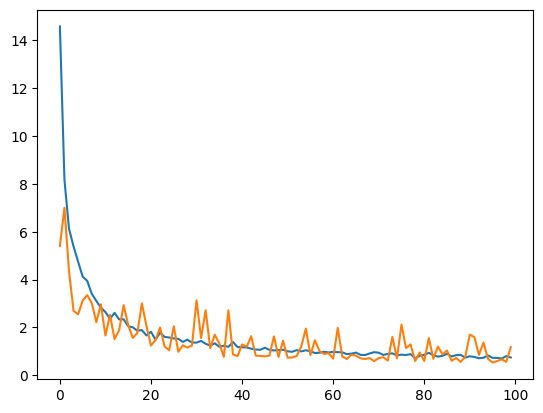

0
1
2


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14940)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1028)           │    15,359,348 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,608,325 (74.80 MB)

 Trainable params: 19,608,085 (74.80 MB)

 Non-trainable params: 240 (960.00 B)

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - MeanAbsoluteError: 24.2311 - loss: 24.2311
Epoch 1: val_loss improved from inf to 10.46343, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - MeanAbsoluteError: 24.2113 - loss: 24.2113 - val_MeanAbsoluteError: 10.4634 - val_loss: 10.4634
Epoch 2/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 7.5082 - loss: 7.5082
Epoch 2: val_loss improved from 10.46343 to 4.70283, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 7.5029 - loss: 7.5029 - val_MeanAbsoluteError: 4.7028 - val_loss: 4.7028
Epoch 3/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.0806 - loss: 5.0806
Epoch 3: val_loss improved from 4.70283 to 3.10712, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 5.0771 - loss: 5.0771 - val_MeanAbsoluteError: 3.1071 - val_loss: 3.1071
Epoch 4/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.7744 - loss: 3.7744
Epoch 4: val_loss did not improve from 3.10712
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.7733 - loss: 3.7733 - val_MeanAbsoluteError: 4.0843 - val_loss: 4.0843
Epoch 5/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.4666 - loss: 3.4666
Epoch 5: val_loss did not improve from 3.10712
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.4648 - loss: 3.4648 - val_MeanAbsoluteError: 3.4990 - val_loss: 3.4990
Epoch 6/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.8121 - loss: 2.8121
Epoch 6: val_loss improved from 3.10712 to 2.87881, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 2.8124 - loss: 2.8124 - val_MeanAbsoluteError: 2.8788 - val_loss: 2.8788
Epoch 7/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.6308 - loss: 2.6308
Epoch 7: val_loss did not improve from 2.87881
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.6302 - loss: 2.6302 - val_MeanAbsoluteError: 2.9085 - val_loss: 2.9085
Epoch 8/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.3964 - loss: 2.3964
Epoch 8: val_loss improved from 2.87881 to 1.99397, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 2.3963 - loss: 2.3963 - val_MeanAbsoluteError: 1.9940 - val_loss: 1.9940
Epoch 9/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.2870 - loss: 2.2870
Epoch 9: val_loss did not improve from 1.99397
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.2865 - loss: 2.2865 - val_MeanAbsoluteError: 2.3392 - val_loss: 2.3392
Epoch 10/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.1645 - loss: 2.1645
Epoch 10: val_loss did not improve from 1.99397
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.1641 - loss: 2.1641 - val_MeanAbsoluteError: 3.3264 - val_loss: 3.3264
Epoch 11/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0788 - loss: 2.0788
Epoch 11: val_loss improved from 1.99397 to 1.92111, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 2.0782 - loss: 2.0782 - val_MeanAbsoluteError: 1.9211 - val_loss: 1.9211
Epoch 12/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.9354 - loss: 1.9354
Epoch 12: val_loss improved from 1.92111 to 1.42399, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 1.9347 - loss: 1.9347 - val_MeanAbsoluteError: 1.4240 - val_loss: 1.4240
Epoch 13/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.0925 - loss: 2.0925
Epoch 13: val_loss improved from 1.42399 to 1.11577, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 2.0912 - loss: 2.0912 - val_MeanAbsoluteError: 1.1158 - val_loss: 1.1158
Epoch 14/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5875 - loss: 1.5875
Epoch 14: val_loss did not improve from 1.11577
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.5876 - loss: 1.5876 - val_MeanAbsoluteError: 2.0210 - val_loss: 2.0210
Epoch 15/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.6154 - loss: 1.6154
Epoch 15: val_loss did not improve from 1.11577
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.6153 - loss: 1.6153 - val_MeanAbsoluteError: 1.2927 - val_loss: 1.2927
Epoch 16/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.6084 - loss: 1.6084
Epoch 16: val_loss improved from 1.11577 to 0.93272, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - MeanAbsoluteError: 1.6079 - loss: 1.6079 - val_MeanAbsoluteError: 0.9327 - val_loss: 0.9327
Epoch 17/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3883 - loss: 1.3883
Epoch 17: val_loss did not improve from 0.93272
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.3885 - loss: 1.3885 - val_MeanAbsoluteError: 1.3748 - val_loss: 1.3748
Epoch 18/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5736 - loss: 1.5736
Epoch 18: val_loss did not improve from 0.93272
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.5734 - loss: 1.5734 - val_MeanAbsoluteError: 1.6490 - val_loss: 1.6490
Epoch 19/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3155 - loss: 1.3155
Epoch 19: val_loss did not improve from 0.93272
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.3155 - loss: 1.3155 - val_MeanAbsoluteError: 0.9699 - val_loss: 0.9699
Epoch 20/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 1.0313 - loss: 1.0313 - val_MeanAbsoluteError: 0.6784 - val_loss: 0.6784
Epoch 29/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8984 - loss: 0.8984
Epoch 29: val_loss did not improve from 0.67836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8986 - loss: 0.8986 - val_MeanAbsoluteError: 0.7066 - val_loss: 0.7066
Epoch 30/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9901 - loss: 0.9901
Epoch 30: val_loss did not improve from 0.67836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.9904 - loss: 0.9904 - val_MeanAbsoluteError: 1.0211 - val_loss: 1.0211
Epoch 31/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9955 - loss: 0.9955
Epoch 31: val_loss did not improve from 0.67836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.9956 - loss: 0.9956 - val_MeanAbsoluteError: 0.7974 - val_loss: 0.7974
Epoch 32/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.8418 - loss: 0.8418 - val_MeanAbsoluteError: 0.6514 - val_loss: 0.6514
Epoch 39/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8202 - loss: 0.8202
Epoch 39: val_loss did not improve from 0.65140
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8210 - loss: 0.8210 - val_MeanAbsoluteError: 2.0517 - val_loss: 2.0517
Epoch 40/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.1895 - loss: 1.1895
Epoch 40: val_loss improved from 0.65140 to 0.63476, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 1.1890 - loss: 1.1890 - val_MeanAbsoluteError: 0.6348 - val_loss: 0.6348
Epoch 41/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8193 - loss: 0.8193
Epoch 41: val_loss did not improve from 0.63476
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8197 - loss: 0.8197 - val_MeanAbsoluteError: 0.7898 - val_loss: 0.7898
Epoch 42/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7748 - loss: 0.7748
Epoch 42: val_loss did not improve from 0.63476
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7750 - loss: 0.7750 - val_MeanAbsoluteError: 0.6944 - val_loss: 0.6944
Epoch 43/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9648 - loss: 0.9648
Epoch 43: val_loss improved from 0.63476 to 0.60418, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.9643 - loss: 0.9643 - val_MeanAbsoluteError: 0.6042 - val_loss: 0.6042
Epoch 44/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8350 - loss: 0.8350
Epoch 44: val_loss did not improve from 0.60418
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8350 - loss: 0.8350 - val_MeanAbsoluteError: 1.1632 - val_loss: 1.1632
Epoch 45/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8120 - loss: 0.8120
Epoch 45: val_loss did not improve from 0.60418
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8121 - loss: 0.8121 - val_MeanAbsoluteError: 1.3286 - val_loss: 1.3286
Epoch 46/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7914 - loss: 0.7914
Epoch 46: val_loss improved from 0.60418 to 0.52098, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.7911 - loss: 0.7911 - val_MeanAbsoluteError: 0.5210 - val_loss: 0.5210
Epoch 47/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9227 - loss: 0.9227
Epoch 47: val_loss did not improve from 0.52098
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.9226 - loss: 0.9226 - val_MeanAbsoluteError: 0.7413 - val_loss: 0.7413
Epoch 48/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6969 - loss: 0.6969
Epoch 48: val_loss did not improve from 0.52098
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6972 - loss: 0.6972 - val_MeanAbsoluteError: 0.6788 - val_loss: 0.6788
Epoch 49/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7461 - loss: 0.7461
Epoch 49: val_loss did not improve from 0.52098
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7461 - loss: 0.7461 - val_MeanAbsoluteError: 0.7480 - val_loss: 0.7480
Epoch 50/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.7433 - loss: 0.7433 - val_MeanAbsoluteError: 0.5104 - val_loss: 0.5104
Epoch 51/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7474 - loss: 0.7474
Epoch 51: val_loss did not improve from 0.51044
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7479 - loss: 0.7479 - val_MeanAbsoluteError: 0.7561 - val_loss: 0.7561
Epoch 52/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6719 - loss: 0.6719
Epoch 52: val_loss did not improve from 0.51044
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6721 - loss: 0.6721 - val_MeanAbsoluteError: 1.2982 - val_loss: 1.2982
Epoch 53/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7168 - loss: 0.7168
Epoch 53: val_loss did not improve from 0.51044
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7167 - loss: 0.7167 - val_MeanAbsoluteError: 1.3155 - val_loss: 1.3155
Epoch 54/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.7937 - loss: 0.7937 - val_MeanAbsoluteError: 0.4965 - val_loss: 0.4965
Epoch 62/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7327 - loss: 0.7327
Epoch 62: val_loss did not improve from 0.49653
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7332 - loss: 0.7332 - val_MeanAbsoluteError: 0.7312 - val_loss: 0.7312
Epoch 63/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7358 - loss: 0.7358
Epoch 63: val_loss did not improve from 0.49653
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7355 - loss: 0.7355 - val_MeanAbsoluteError: 0.6449 - val_loss: 0.6449
Epoch 64/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.7155 - loss: 0.7155
Epoch 64: val_loss did not improve from 0.49653
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7154 - loss: 0.7154 - val_MeanAbsoluteError: 0.8924 - val_loss: 0.8924
Epoch 65/100
445/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.6520 - loss: 0.6520 - val_MeanAbsoluteError: 0.4760 - val_loss: 0.4760
Epoch 75/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5874 - loss: 0.5874
Epoch 75: val_loss did not improve from 0.47598
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5875 - loss: 0.5875 - val_MeanAbsoluteError: 1.3690 - val_loss: 1.3690
Epoch 76/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6404 - loss: 0.6404
Epoch 76: val_loss did not improve from 0.47598
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6400 - loss: 0.6400 - val_MeanAbsoluteError: 0.5288 - val_loss: 0.5288
Epoch 77/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5935 - loss: 0.5935
Epoch 77: val_loss improved from 0.47598 to 0.45310, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.5937 - loss: 0.5937 - val_MeanAbsoluteError: 0.4531 - val_loss: 0.4531
Epoch 78/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6258 - loss: 0.6258
Epoch 78: val_loss did not improve from 0.45310
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6258 - loss: 0.6258 - val_MeanAbsoluteError: 0.7389 - val_loss: 0.7389
Epoch 79/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6164 - loss: 0.6164
Epoch 79: val_loss improved from 0.45310 to 0.39869, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.6165 - loss: 0.6165 - val_MeanAbsoluteError: 0.3987 - val_loss: 0.3987
Epoch 80/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5956 - loss: 0.5956
Epoch 80: val_loss did not improve from 0.39869
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5957 - loss: 0.5957 - val_MeanAbsoluteError: 0.4623 - val_loss: 0.4623
Epoch 81/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5479 - loss: 0.5479
Epoch 81: val_loss did not improve from 0.39869
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5481 - loss: 0.5481 - val_MeanAbsoluteError: 1.1007 - val_loss: 1.1007
Epoch 82/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5556 - loss: 0.5556
Epoch 82: val_loss improved from 0.39869 to 0.37701, saving model to ../models/reference/cnn_3_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - MeanAbsoluteError: 0.5557 - loss: 0.5557 - val_MeanAbsoluteError: 0.3770 - val_loss: 0.3770
Epoch 83/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.5228 - loss: 0.5228
Epoch 83: val_loss did not improve from 0.37701
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5229 - loss: 0.5229 - val_MeanAbsoluteError: 1.7032 - val_loss: 1.7032
Epoch 84/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6080 - loss: 0.6080
Epoch 84: val_loss did not improve from 0.37701
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6079 - loss: 0.6079 - val_MeanAbsoluteError: 1.2677 - val_loss: 1.2677
Epoch 85/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.6349 - loss: 0.6349
Epoch 85: val_loss did not improve from 0.37701
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6347 - loss: 0.6347 - val_MeanAbsoluteError: 0.8910 - val_loss: 0.8910
Epoch 86/100
445/447 ━━━

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4171 - mean_absolute_error: 5.4171


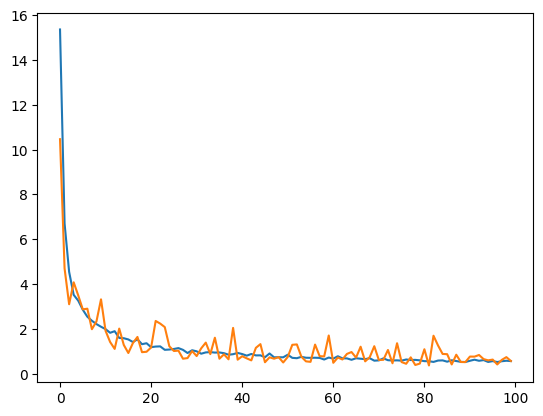

0
1
2
3


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 245, 80)        │        24,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 245, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 245, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 121, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1028)           │     9,952,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 1028)           │             

 Total params: 14,225,445 (54.27 MB)

 Trainable params: 14,225,045 (54.26 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - MeanAbsoluteError: 24.9620 - loss: 24.9620
Epoch 1: val_loss improved from inf to 6.56206, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - MeanAbsoluteError: 24.9403 - loss: 24.9403 - val_MeanAbsoluteError: 6.5621 - val_loss: 6.5621
Epoch 2/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 6.3002 - loss: 6.3002
Epoch 2: val_loss improved from 6.56206 to 3.50963, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 6.2910 - loss: 6.2910 - val_MeanAbsoluteError: 3.5096 - val_loss: 3.5096
Epoch 3/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 4.3570 - loss: 4.3570
Epoch 3: val_loss did not improve from 3.50963
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 4.3553 - loss: 4.3553 - val_MeanAbsoluteError: 4.4890 - val_loss: 4.4890
Epoch 4/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.8126 - loss: 3.8126
Epoch 4: val_loss improved from 3.50963 to 2.85672, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.8107 - loss: 3.8107 - val_MeanAbsoluteError: 2.8567 - val_loss: 2.8567
Epoch 5/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.5633 - loss: 3.5633
Epoch 5: val_loss improved from 2.85672 to 2.53182, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 3.5617 - loss: 3.5617 - val_MeanAbsoluteError: 2.5318 - val_loss: 2.5318
Epoch 6/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.8733 - loss: 2.8733
Epoch 6: val_loss improved from 2.53182 to 2.29678, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.8728 - loss: 2.8728 - val_MeanAbsoluteError: 2.2968 - val_loss: 2.2968
Epoch 7/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.8093 - loss: 2.8093
Epoch 7: val_loss did not improve from 2.29678
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.8085 - loss: 2.8085 - val_MeanAbsoluteError: 2.8147 - val_loss: 2.8147
Epoch 8/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.4853 - loss: 2.4853
Epoch 8: val_loss did not improve from 2.29678
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.4858 - loss: 2.4858 - val_MeanAbsoluteError: 2.3712 - val_loss: 2.3712
Epoch 9/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.2447 - loss: 2.2447
Epoch 9: val_loss improved from 2.29678 to 1.89403, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.2447 - loss: 2.2447 - val_MeanAbsoluteError: 1.8940 - val_loss: 1.8940
Epoch 10/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.1065 - loss: 2.1065
Epoch 10: val_loss did not improve from 1.89403
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.1074 - loss: 2.1074 - val_MeanAbsoluteError: 2.7788 - val_loss: 2.7788
Epoch 11/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.0062 - loss: 2.0062
Epoch 11: val_loss improved from 1.89403 to 1.72492, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.0061 - loss: 2.0061 - val_MeanAbsoluteError: 1.7249 - val_loss: 1.7249
Epoch 12/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.8842 - loss: 1.8842
Epoch 12: val_loss did not improve from 1.72492
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.8840 - loss: 1.8840 - val_MeanAbsoluteError: 1.9977 - val_loss: 1.9977
Epoch 13/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.7880 - loss: 1.7880
Epoch 13: val_loss improved from 1.72492 to 1.35640, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.7878 - loss: 1.7878 - val_MeanAbsoluteError: 1.3564 - val_loss: 1.3564
Epoch 14/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.6215 - loss: 1.6215
Epoch 14: val_loss did not improve from 1.35640
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.6215 - loss: 1.6215 - val_MeanAbsoluteError: 1.5424 - val_loss: 1.5424
Epoch 15/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.4914 - loss: 1.4914
Epoch 15: val_loss did not improve from 1.35640
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.4927 - loss: 1.4927 - val_MeanAbsoluteError: 1.7308 - val_loss: 1.7308
Epoch 16/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.4025 - loss: 1.4025
Epoch 16: val_loss improved from 1.35640 to 1.30252, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.4023 - loss: 1.4023 - val_MeanAbsoluteError: 1.3025 - val_loss: 1.3025
Epoch 17/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3330 - loss: 1.3330
Epoch 17: val_loss did not improve from 1.30252
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.3327 - loss: 1.3327 - val_MeanAbsoluteError: 2.2953 - val_loss: 2.2953
Epoch 18/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.4768 - loss: 1.4768
Epoch 18: val_loss improved from 1.30252 to 1.30045, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.4769 - loss: 1.4769 - val_MeanAbsoluteError: 1.3005 - val_loss: 1.3005
Epoch 19/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3449 - loss: 1.3449
Epoch 19: val_loss improved from 1.30045 to 1.11450, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.3450 - loss: 1.3450 - val_MeanAbsoluteError: 1.1145 - val_loss: 1.1145
Epoch 20/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.1612 - loss: 1.1612
Epoch 20: val_loss did not improve from 1.11450
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.1618 - loss: 1.1618 - val_MeanAbsoluteError: 1.7462 - val_loss: 1.7462
Epoch 21/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.1827 - loss: 1.1827
Epoch 21: val_loss did not improve from 1.11450
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.1822 - loss: 1.1822 - val_MeanAbsoluteError: 1.3950 - val_loss: 1.3950
Epoch 22/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0995 - loss: 1.0995
Epoch 22: val_loss improved from 1.11450 to 0.87288, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.0994 - loss: 1.0994 - val_MeanAbsoluteError: 0.8729 - val_loss: 0.8729
Epoch 23/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3698 - loss: 1.3698
Epoch 23: val_loss did not improve from 0.87288
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.3695 - loss: 1.3695 - val_MeanAbsoluteError: 1.2700 - val_loss: 1.2700
Epoch 24/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0864 - loss: 1.0864
Epoch 24: val_loss improved from 0.87288 to 0.79380, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.0863 - loss: 1.0863 - val_MeanAbsoluteError: 0.7938 - val_loss: 0.7938
Epoch 25/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0800 - loss: 1.0800
Epoch 25: val_loss did not improve from 0.79380
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.0802 - loss: 1.0802 - val_MeanAbsoluteError: 1.8100 - val_loss: 1.8100
Epoch 26/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.1385 - loss: 1.1385
Epoch 26: val_loss did not improve from 0.79380
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.1379 - loss: 1.1379 - val_MeanAbsoluteError: 1.6663 - val_loss: 1.6663
Epoch 27/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0568 - loss: 1.0568
Epoch 27: val_loss improved from 0.79380 to 0.70662, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0564 - loss: 1.0564 - val_MeanAbsoluteError: 0.7066 - val_loss: 0.7066
Epoch 28/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.9259 - loss: 0.9259
Epoch 28: val_loss did not improve from 0.70662
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.9264 - loss: 0.9264 - val_MeanAbsoluteError: 1.1558 - val_loss: 1.1558
Epoch 29/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.9797 - loss: 0.9797
Epoch 29: val_loss did not improve from 0.70662
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.9803 - loss: 0.9803 - val_MeanAbsoluteError: 1.0603 - val_loss: 1.0603
Epoch 30/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.9295 - loss: 0.9295
Epoch 30: val_loss did not improve from 0.70662
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.9294 - loss: 0.9294 - val_MeanAbsoluteError: 0.8160 - val_loss: 0.8160
Epoch 31/100
442/447 ━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.9128 - loss: 0.9128 - val_MeanAbsoluteError: 0.6607 - val_loss: 0.6607
Epoch 38/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.7292 - loss: 0.7292
Epoch 38: val_loss did not improve from 0.66075
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.7295 - loss: 0.7295 - val_MeanAbsoluteError: 0.7503 - val_loss: 0.7503
Epoch 39/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8638 - loss: 0.8638
Epoch 39: val_loss did not improve from 0.66075
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.8640 - loss: 0.8640 - val_MeanAbsoluteError: 1.3934 - val_loss: 1.3934
Epoch 40/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8792 - loss: 0.8792
Epoch 40: val_loss improved from 0.66075 to 0.64581, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.8792 - loss: 0.8792 - val_MeanAbsoluteError: 0.6458 - val_loss: 0.6458
Epoch 41/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8069 - loss: 0.8069
Epoch 41: val_loss did not improve from 0.64581
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.8072 - loss: 0.8072 - val_MeanAbsoluteError: 0.8227 - val_loss: 0.8227
Epoch 42/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.7616 - loss: 0.7616
Epoch 42: val_loss improved from 0.64581 to 0.55415, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7613 - loss: 0.7613 - val_MeanAbsoluteError: 0.5542 - val_loss: 0.5542
Epoch 43/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.7255 - loss: 0.7255
Epoch 43: val_loss did not improve from 0.55415
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.7254 - loss: 0.7254 - val_MeanAbsoluteError: 0.6236 - val_loss: 0.6236
Epoch 44/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6773 - loss: 0.6773
Epoch 44: val_loss did not improve from 0.55415
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6777 - loss: 0.6777 - val_MeanAbsoluteError: 2.2535 - val_loss: 2.2535
Epoch 45/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6939 - loss: 0.6939
Epoch 45: val_loss did not improve from 0.55415
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6939 - loss: 0.6939 - val_MeanAbsoluteError: 0.7032 - val_loss: 0.7032
Epoch 46/100
442/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.7302 - loss: 0.7302 - val_MeanAbsoluteError: 0.5384 - val_loss: 0.5384
Epoch 54/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6498 - loss: 0.6498
Epoch 54: val_loss did not improve from 0.53836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6497 - loss: 0.6497 - val_MeanAbsoluteError: 0.6838 - val_loss: 0.6838
Epoch 55/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6649 - loss: 0.6649
Epoch 55: val_loss did not improve from 0.53836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6652 - loss: 0.6652 - val_MeanAbsoluteError: 0.6406 - val_loss: 0.6406
Epoch 56/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6104 - loss: 0.6104
Epoch 56: val_loss did not improve from 0.53836
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6110 - loss: 0.6110 - val_MeanAbsoluteError: 0.9447 - val_loss: 0.9447
Epoch 57/100
441/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6315 - loss: 0.6315 - val_MeanAbsoluteError: 0.4034 - val_loss: 0.4034
Epoch 68/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5223 - loss: 0.5223
Epoch 68: val_loss did not improve from 0.40343
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5229 - loss: 0.5229 - val_MeanAbsoluteError: 0.5964 - val_loss: 0.5964
Epoch 69/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5551 - loss: 0.5551
Epoch 69: val_loss improved from 0.40343 to 0.38753, saving model to ../models/reference/cnn_4_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5551 - loss: 0.5551 - val_MeanAbsoluteError: 0.3875 - val_loss: 0.3875
Epoch 70/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5491 - loss: 0.5491
Epoch 70: val_loss did not improve from 0.38753
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5493 - loss: 0.5493 - val_MeanAbsoluteError: 1.2917 - val_loss: 1.2917
Epoch 71/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6215 - loss: 0.6215
Epoch 71: val_loss did not improve from 0.38753
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6209 - loss: 0.6209 - val_MeanAbsoluteError: 0.4312 - val_loss: 0.4312
Epoch 72/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5811 - loss: 0.5811
Epoch 72: val_loss did not improve from 0.38753
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5820 - loss: 0.5820 - val_MeanAbsoluteError: 0.4370 - val_loss: 0.4370
Epoch 73/100
442/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.5121 - loss: 0.5121 - val_MeanAbsoluteError: 0.3391 - val_loss: 0.3391
Epoch 85/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5006 - loss: 0.5006
Epoch 85: val_loss did not improve from 0.33907
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5009 - loss: 0.5009 - val_MeanAbsoluteError: 0.5836 - val_loss: 0.5836
Epoch 86/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5396 - loss: 0.5396
Epoch 86: val_loss did not improve from 0.33907
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5394 - loss: 0.5394 - val_MeanAbsoluteError: 0.6378 - val_loss: 0.6378
Epoch 87/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5446 - loss: 0.5446
Epoch 87: val_loss did not improve from 0.33907
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5444 - loss: 0.5444 - val_MeanAbsoluteError: 0.4903 - val_loss: 0.4903
Epoch 88/100
442/447 ━━━━

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4638 - mean_absolute_error: 5.4638


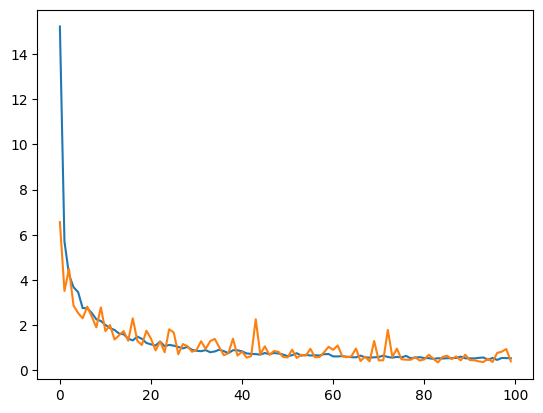

0
1
2
3
4


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 245, 80)        │        24,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 245, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 245, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 121, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 117, 100)       │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 117, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 117, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 57, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5700)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,174,505 (38.81 MB)

 Trainable params: 10,173,905 (38.81 MB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - MeanAbsoluteError: 26.8459 - loss: 26.8459
Epoch 1: val_loss improved from inf to 11.34764, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - MeanAbsoluteError: 26.8235 - loss: 26.8235 - val_MeanAbsoluteError: 11.3476 - val_loss: 11.3476
Epoch 2/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 7.3871 - loss: 7.3871
Epoch 2: val_loss improved from 11.34764 to 4.73812, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 7.3827 - loss: 7.3827 - val_MeanAbsoluteError: 4.7381 - val_loss: 4.7381
Epoch 3/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 4.8130 - loss: 4.8130
Epoch 3: val_loss improved from 4.73812 to 4.59382, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 4.8109 - loss: 4.8109 - val_MeanAbsoluteError: 4.5938 - val_loss: 4.5938
Epoch 4/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.9163 - loss: 3.9163
Epoch 4: val_loss improved from 4.59382 to 3.13961, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 3.9156 - loss: 3.9156 - val_MeanAbsoluteError: 3.1396 - val_loss: 3.1396
Epoch 5/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.4446 - loss: 3.4446
Epoch 5: val_loss improved from 3.13961 to 2.82744, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 3.4447 - loss: 3.4447 - val_MeanAbsoluteError: 2.8274 - val_loss: 2.8274
Epoch 6/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.9868 - loss: 2.9868
Epoch 6: val_loss improved from 2.82744 to 2.39627, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 2.9862 - loss: 2.9862 - val_MeanAbsoluteError: 2.3963 - val_loss: 2.3963
Epoch 7/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.6781 - loss: 2.6781
Epoch 7: val_loss did not improve from 2.39627
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.6773 - loss: 2.6773 - val_MeanAbsoluteError: 3.1512 - val_loss: 3.1512
Epoch 8/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.5734 - loss: 2.5734
Epoch 8: val_loss improved from 2.39627 to 2.32446, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.5732 - loss: 2.5732 - val_MeanAbsoluteError: 2.3245 - val_loss: 2.3245
Epoch 9/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.3864 - loss: 2.3864
Epoch 9: val_loss improved from 2.32446 to 2.20837, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.3860 - loss: 2.3860 - val_MeanAbsoluteError: 2.2084 - val_loss: 2.2084
Epoch 10/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.1282 - loss: 2.1282
Epoch 10: val_loss improved from 2.20837 to 1.77855, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 2.1281 - loss: 2.1281 - val_MeanAbsoluteError: 1.7785 - val_loss: 1.7785
Epoch 11/100
440/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9533 - loss: 1.9533
Epoch 11: val_loss improved from 1.77855 to 1.56150, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.9532 - loss: 1.9532 - val_MeanAbsoluteError: 1.5615 - val_loss: 1.5615
Epoch 12/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9800 - loss: 1.9800
Epoch 12: val_loss improved from 1.56150 to 1.34165, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 1.9798 - loss: 1.9798 - val_MeanAbsoluteError: 1.3416 - val_loss: 1.3416
Epoch 13/100
440/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.7388 - loss: 1.7388
Epoch 13: val_loss did not improve from 1.34165
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.7393 - loss: 1.7393 - val_MeanAbsoluteError: 3.8811 - val_loss: 3.8811
Epoch 14/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9190 - loss: 1.9190
Epoch 14: val_loss did not improve from 1.34165
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.9176 - loss: 1.9176 - val_MeanAbsoluteError: 1.5015 - val_loss: 1.5015
Epoch 15/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9310 - loss: 1.9310
Epoch 15: val_loss improved from 1.34165 to 1.11226, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.9285 - loss: 1.9285 - val_MeanAbsoluteError: 1.1123 - val_loss: 1.1123
Epoch 16/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.6219 - loss: 1.6219
Epoch 16: val_loss did not improve from 1.11226
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.6215 - loss: 1.6215 - val_MeanAbsoluteError: 2.5598 - val_loss: 2.5598
Epoch 17/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.6843 - loss: 1.6843
Epoch 17: val_loss did not improve from 1.11226
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.6828 - loss: 1.6828 - val_MeanAbsoluteError: 1.4304 - val_loss: 1.4304
Epoch 18/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2849 - loss: 1.2849
Epoch 18: val_loss did not improve from 1.11226
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2843 - loss: 1.2843 - val_MeanAbsoluteError: 3.1431 - val_loss: 3.1431
Epoch 19/100
441/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.2612 - loss: 1.2612 - val_MeanAbsoluteError: 0.9305 - val_loss: 0.9305
Epoch 21/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1473 - loss: 1.1473
Epoch 21: val_loss did not improve from 0.93055
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.1474 - loss: 1.1474 - val_MeanAbsoluteError: 1.0892 - val_loss: 1.0892
Epoch 22/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1114 - loss: 1.1114
Epoch 22: val_loss did not improve from 0.93055
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1119 - loss: 1.1119 - val_MeanAbsoluteError: 2.4229 - val_loss: 2.4229
Epoch 23/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1220 - loss: 1.1220
Epoch 23: val_loss did not improve from 0.93055
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1216 - loss: 1.1216 - val_MeanAbsoluteError: 1.0913 - val_loss: 1.0913
Epoch 24/100
442/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 1.0472 - loss: 1.0472 - val_MeanAbsoluteError: 0.8349 - val_loss: 0.8349
Epoch 26/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1300 - loss: 1.1300
Epoch 26: val_loss did not improve from 0.83492
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1296 - loss: 1.1296 - val_MeanAbsoluteError: 1.0457 - val_loss: 1.0457
Epoch 27/100
440/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.0051 - loss: 1.0051
Epoch 27: val_loss did not improve from 0.83492
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.0051 - loss: 1.0051 - val_MeanAbsoluteError: 0.9548 - val_loss: 0.9548
Epoch 28/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8716 - loss: 0.8716
Epoch 28: val_loss improved from 0.83492 to 0.56760, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.8718 - loss: 0.8718 - val_MeanAbsoluteError: 0.5676 - val_loss: 0.5676
Epoch 29/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8691 - loss: 0.8691
Epoch 29: val_loss did not improve from 0.56760
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.8701 - loss: 0.8701 - val_MeanAbsoluteError: 1.1997 - val_loss: 1.1997
Epoch 30/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9889 - loss: 0.9889
Epoch 30: val_loss did not improve from 0.56760
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.9883 - loss: 0.9883 - val_MeanAbsoluteError: 1.2375 - val_loss: 1.2375
Epoch 31/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9256 - loss: 0.9256
Epoch 31: val_loss did not improve from 0.56760
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.9248 - loss: 0.9248 - val_MeanAbsoluteError: 0.7963 - val_loss: 0.7963
Epoch 32/100
445/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.8915 - loss: 0.8915 - val_MeanAbsoluteError: 0.4211 - val_loss: 0.4211
Epoch 46/100
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7005 - loss: 0.7005
Epoch 46: val_loss did not improve from 0.42106
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7005 - loss: 0.7005 - val_MeanAbsoluteError: 0.8122 - val_loss: 0.8122
Epoch 47/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8066 - loss: 0.8066
Epoch 47: val_loss did not improve from 0.42106
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.8064 - loss: 0.8064 - val_MeanAbsoluteError: 0.5727 - val_loss: 0.5727
Epoch 48/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7139 - loss: 0.7139
Epoch 48: val_loss did not improve from 0.42106
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7138 - loss: 0.7138 - val_MeanAbsoluteError: 0.5090 - val_loss: 0.5090
Epoch 49/100
445/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.6485 - loss: 0.6485 - val_MeanAbsoluteError: 0.3837 - val_loss: 0.3837
Epoch 57/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.6324 - loss: 0.6324
Epoch 57: val_loss did not improve from 0.38366
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.6324 - loss: 0.6324 - val_MeanAbsoluteError: 0.7822 - val_loss: 0.7822
Epoch 58/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.6302 - loss: 0.6302
Epoch 58: val_loss did not improve from 0.38366
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.6303 - loss: 0.6303 - val_MeanAbsoluteError: 0.5119 - val_loss: 0.5119
Epoch 59/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.5655 - loss: 0.5655
Epoch 59: val_loss did not improve from 0.38366
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.5655 - loss: 0.5655 - val_MeanAbsoluteError: 0.4565 - val_loss: 0.4565
Epoch 60/100
441/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.5213 - loss: 0.5213 - val_MeanAbsoluteError: 0.3691 - val_loss: 0.3691
Epoch 70/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.4841 - loss: 0.4841
Epoch 70: val_loss did not improve from 0.36907
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.4841 - loss: 0.4841 - val_MeanAbsoluteError: 0.4546 - val_loss: 0.4546
Epoch 71/100
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.5424 - loss: 0.5424
Epoch 71: val_loss did not improve from 0.36907
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.5426 - loss: 0.5426 - val_MeanAbsoluteError: 0.8903 - val_loss: 0.8903
Epoch 72/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.6290 - loss: 0.6290
Epoch 72: val_loss improved from 0.36907 to 0.29574, saving model to ../models/reference/cnn_5_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MeanAbsoluteError: 0.6283 - loss: 0.6283 - val_MeanAbsoluteError: 0.2957 - val_loss: 0.2957
Epoch 73/100
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.5436 - loss: 0.5436
Epoch 73: val_loss did not improve from 0.29574
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.5434 - loss: 0.5434 - val_MeanAbsoluteError: 0.7361 - val_loss: 0.7361
Epoch 74/100
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.5156 - loss: 0.5156
Epoch 74: val_loss did not improve from 0.29574
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.5165 - loss: 0.5165 - val_MeanAbsoluteError: 0.3894 - val_loss: 0.3894
Epoch 75/100
440/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.5414 - loss: 0.5414
Epoch 75: val_loss did not improve from 0.29574
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.5415 - loss: 0.5415 - val_MeanAbsoluteError: 0.3938 - val_loss: 0.3938
Epoch 76/100
446/447 ━━━━

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MeanAbsoluteError: 0.4785 - loss: 0.4785 - val_MeanAbsoluteError: 0.2612 - val_loss: 0.2612
Epoch 100/100
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.4823 - loss: 0.4823
Epoch 100: val_loss did not improve from 0.26116
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.4822 - loss: 0.4822 - val_MeanAbsoluteError: 0.2953 - val_loss: 0.2953


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.7801 - mean_absolute_error: 4.7801


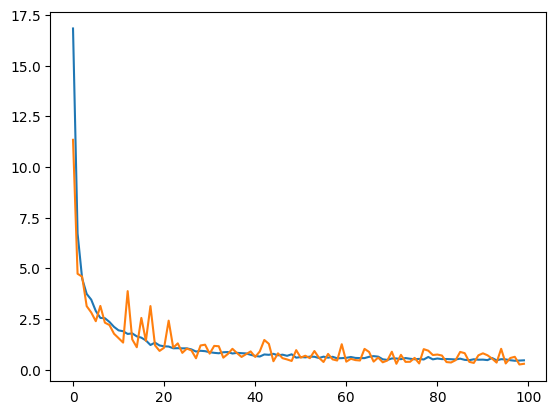

In [ ]:
if not use_reference_models:
    for i in range(1,nMaxConvLayers+1):
        train_models(i)

#### Evaluation

In [ ]:
X_val.shape

(7932, 2048)

In [ ]:
X_val_1 = X_val[:len(y0_val),:]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val),:]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val),:]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val),:]
X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:]

In [ ]:
accuracies = []
accuracies_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

Resultados 1 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0166 - mean_absolute_error: 0.0166
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 13.5374 - mean_absolute_error: 13.5374
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1849 - mean_absolute_error: 6.1849
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3207 - mean_absolute_error: 5.3207
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 3.6985 - mean_absolute_error: 3.6985
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5452 - mean_absolute_error: 4.5452


Resultados 2 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0011
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 10.8941 - mean_absolute_error: 10.8941
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0974 - mean_absolute_error: 8.0974
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1182 - mean_absolute_error: 3.1182
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4853 - mean_absolute_error: 1.4853
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9143 - mean_absolute_error: 3.9143


Resultados 3 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0364 - mean_absolute_error: 0.0364
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 13.2747 - mean_absolute_error: 13.2747
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9709 - mean_absolute_error: 13.9709
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0333 - mean_absolute_error: 4.0333
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9248 - mean_absolute_error: 0.9248
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4171 - mean_absolute_error: 5.4171


Resultados 4 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0016
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 12.4755 - mean_absolute_error: 12.4755
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.1978 - mean_absolute_error: 14.1978
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2743 - mean_absolute_error: 6.2743
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8574 - mean_absolute_error: 0.8574
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4638 - mean_absolute_error: 5.4638


Resultados 5 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0266 - mean_absolute_error: 0.0266
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.9760 - mean_absolute_error: 9.9760
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5339 - mean_absolute_error: 10.5339
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9739 - mean_absolute_error: 7.9739
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7082 - mean_absolute_error: 0.7082
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7801 - mean_absolute_error: 4.7801


In [ ]:
accuracies_all

array([5.66684055, 4.6961298 , 6.36346531, 6.86542463, 6.66181183])

In [ ]:
accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

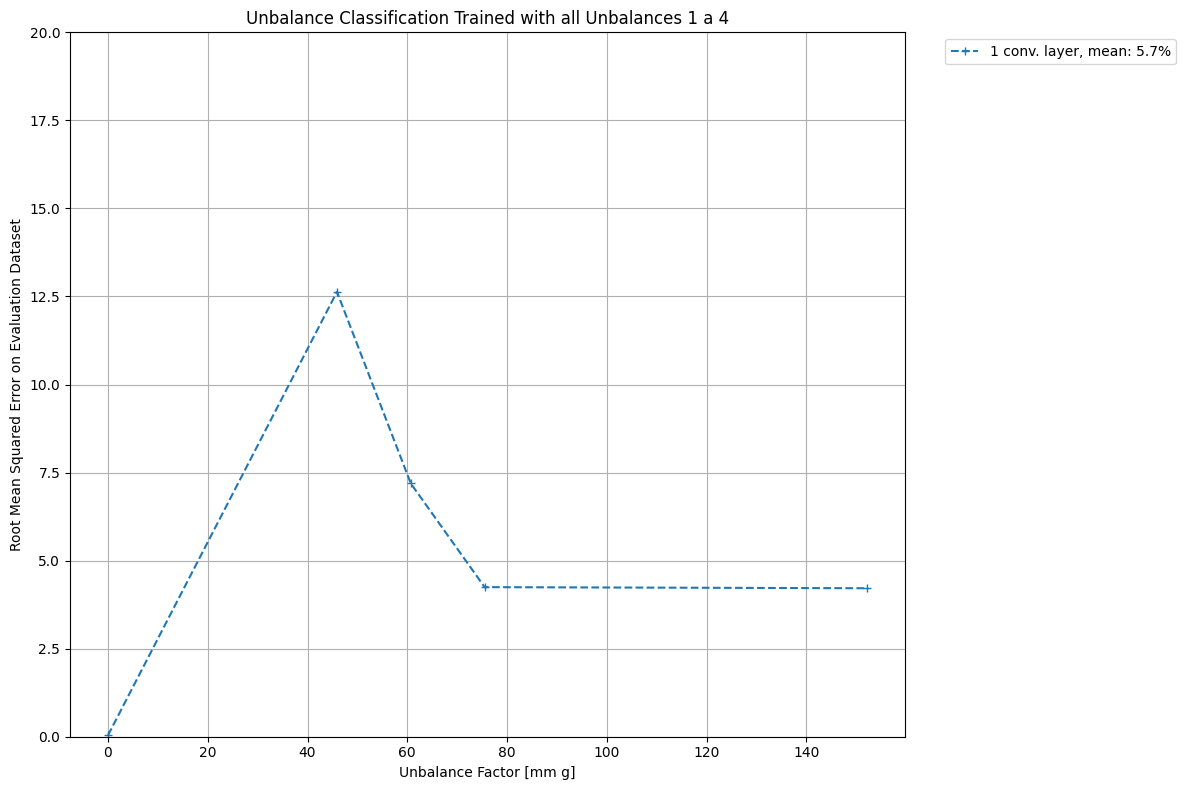

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances 1 a 4")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], label=f"1 conv. layer, mean: {accuracies_all[0]:.1f}%", marker="+", ls="--")
#ax1.plot(1e6*unbalances, accuracies[1,:], label=f"2 conv. layers, mean: {accuracies_all[1]:.1f}%", marker="+", ls="--")
#ax1.plot(1e6*unbalances, accuracies[2,:], label=f"3 conv. layers, mean: {accuracies_all[2]:.1f}%", marker="+", ls="--")
#ax1.plot(1e6*unbalances, accuracies[3,:], label=f"4 conv. layers, mean: {accuracies_all[3]:.1f}%", marker="+", ls="--")
plt.ylabel("Root Mean Squared Error on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0, 20])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances 5 a 8")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[4,:], label=f"5 conv. layer, mean: {accuracies_all[4]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[5,:], label=f"6 conv. layers, mean: {accuracies_all[5]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[5,:], label=f"7 conv. layers, mean: {accuracies_all[6]:.1f}%", marker="+", ls="--")
#ax1.plot(1e6*unbalances, accuracies[7,:], label=f"8 conv. layers, mean: {accuracies_all[7]:.1f}%", marker="+", ls="--")
plt.ylabel("Root Mean Squared Error on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0, 20])
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nfig=plt.figure(figsize=(12,8))\nax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances 5 a 8")\nunbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])\nax1.plot(1e6*unbalances, accuracies[4,:], label=f"5 conv. layer, mean: {accuracies_all[4]:.1f}%", marker="+", ls="--")\nax1.plot(1e6*unbalances, accuracies[5,:], label=f"6 conv. layers, mean: {accuracies_all[5]:.1f}%", marker="+", ls="--")\nax1.plot(1e6*unbalances, accuracies[5,:], label=f"7 conv. layers, mean: {accuracies_all[6]:.1f}%", marker="+", ls="--")\n#ax1.plot(1e6*unbalances, accuracies[7,:], label=f"8 conv. layers, mean: {accuracies_all[7]:.1f}%", marker="+", ls="--")\nplt.ylabel("Root Mean Squared Error on Evaluation Dataset")\nplt.xlabel("Unbalance Factor [mm g]")\nplt.legend(bbox_to_anchor=(1.04,1), loc="upper left")\nplt.ylim([0, 20])\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
predictions_by_class = []
predictions_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    y_pred_1 = model_i.predict(X_val_1)
    y_pred_2 = model_i.predict(X_val_2)
    y_pred_3 = model_i.predict(X_val_3)
    y_pred_4 = model_i.predict(X_val_4)
    y_pred_5 = model_i.predict(X_val_5)
    y_pred_all = model_i.predict(X_val)
    predictions_layer_i = [ y_pred_1,  y_pred_2,  y_pred_3,  y_pred_4,  y_pred_5]
    predictions_by_class.append(predictions_layer_i)
    predictions_all.append(y_pred_all)

#predictions_by_class = np.array(predictions_by_class)
#predictions_all = np.array(predictions_all)

Resultados 1 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Resultados 2 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Resultados 3 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Resultados 4 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Resultados 5 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
def imprime_resultado(lista_de_previsoes, qde_camadas, classe):
  baselines = [0.0, 45.9, 60.7, 75.5, 152,1]
  plt.plot(lista_de_previsoes[qde_camadas-1][classe])
  x_max = len(lista_de_previsoes[qde_camadas-1][classe])
  plt.hlines(y=baselines[classe], xmin=0, xmax=x_max, colors=['r'], linestyles=['--'])
  plt.ylim([-20,180])
  plt.show()
  return

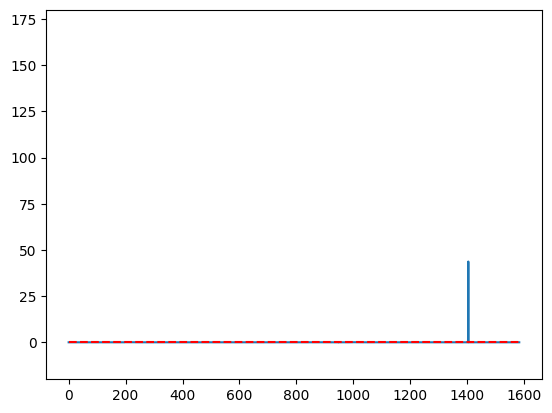

In [ ]:
imprime_resultado(predictions_by_class, 1, 0)

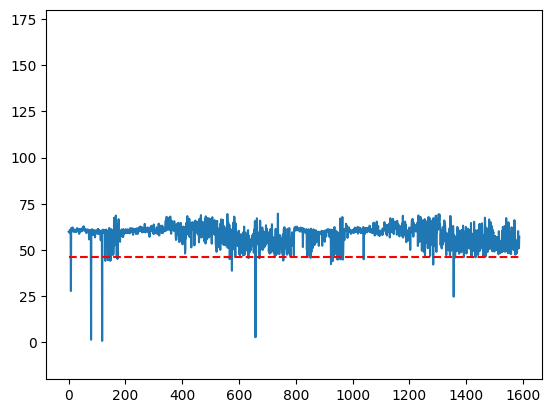

In [ ]:
imprime_resultado(predictions_by_class, 1, 1)

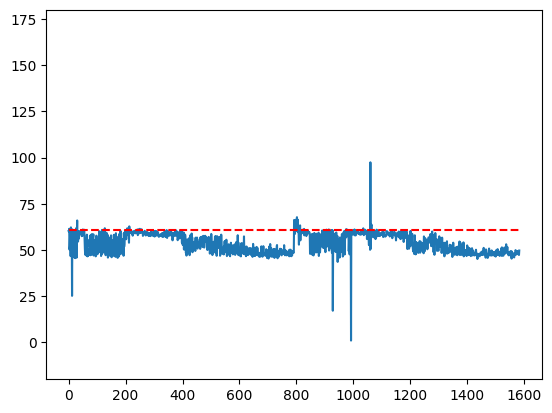

In [ ]:
imprime_resultado(predictions_by_class, 1, 2)

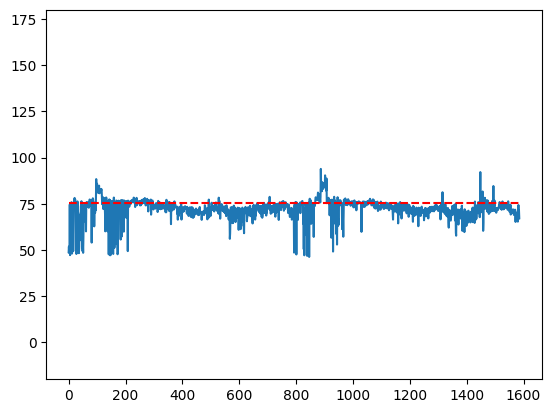

In [ ]:
imprime_resultado(predictions_by_class, 1, 3)

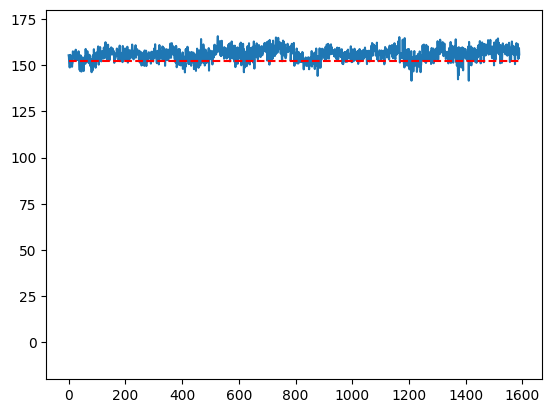

In [ ]:
imprime_resultado(predictions_by_class, 1, 4)

In [ ]:
def imprime_todos_resultados(lista_de_previsoes, qde_camadas):
  baselines = [0.0, 45.9, 60.7, 75.5, 152,1]
  for classe in range(5):
    plt.plot(lista_de_previsoes[qde_camadas-1][classe])
    x_max = len(lista_de_previsoes[qde_camadas-1][classe])
    plt.hlines(y=baselines[classe], xmin=0, xmax=x_max, colors=['k'], linestyles=['--'])
    plt.ylim([-20,180])
  plt.show()
  return

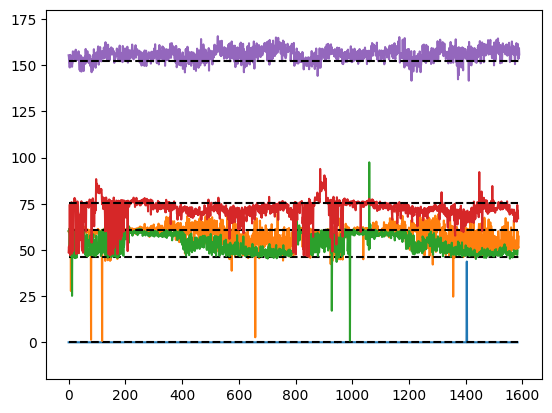

In [ ]:
imprime_todos_resultados(predictions_by_class, qde_camadas = 1)

**SEABORN**

**Histogramas**

In [ ]:
len(y_pred_1), len(y_pred_2), len(y_pred_3), len(y_pred_4), len(y_pred_5)

(1584, 1588, 1584, 1586, 1590)

In [ ]:
previsoes = np.concatenate([y_pred_1[:1584], y_pred_2[:1584], y_pred_3[:1584], y_pred_4[:1584], y_pred_5[:1584]], axis=1)


In [ ]:
previsoes.shape

(1584, 5)

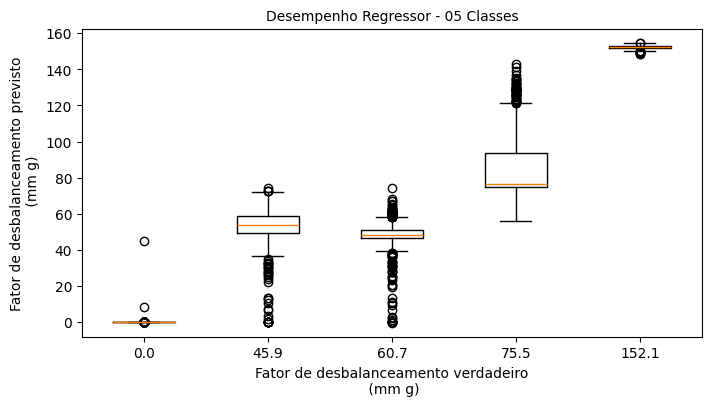

In [ ]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(8,4))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(previsoes,  vert = 0, patch_artist = False)


# Adicionando Título ao gráfico
plt.title("Desempenho Regressor - 05 Classes", loc="center", fontsize=10)
plt.xlabel("Fator de desbalanceamento verdadeiro\n (mm g)")
ticks = [1,2,3,4,5]  # Positions for the ticks
labels = [0.0, 45.9, 60.7, 75.5, 152.1]  # Labels for the ticks
plt.xticks(ticks, labels)  # Set the ticks and labels
plt.ylabel("Fator de desbalanceamento previsto\n (mm g)")

plt.show()

**Distribuições**

In [ ]:
df_predict = pd.DataFrame(previsoes)

In [ ]:
df_predict.head()

,0,1,2,3,4
0,0.000075,22.074198,55.773266,69.225800,152.101334
1,0.000112,57.310677,57.393044,66.410950,151.941986
2,0.000368,56.091797,60.580204,62.438454,152.771271
3,0.000130,12.137660,53.668129,69.830978,152.059860
4,0.000021,44.385944,56.445625,75.681274,152.667892


In [ ]:
df_predict.columns=['FDesb: 0,0','FDesb: 45,9','FDesb: 60,7','FDesb: 75,5','FDesb: 152,1']

In [ ]:
df_predict.head()

,"FDesb: 0,0","FDesb: 45,9","FDesb: 60,7","FDesb: 75,5","FDesb: 152,1"
0,0.000075,22.074198,55.773266,69.225800,152.101334
1,0.000112,57.310677,57.393044,66.410950,151.941986
2,0.000368,56.091797,60.580204,62.438454,152.771271
3,0.000130,12.137660,53.668129,69.830978,152.059860
4,0.000021,44.385944,56.445625,75.681274,152.667892


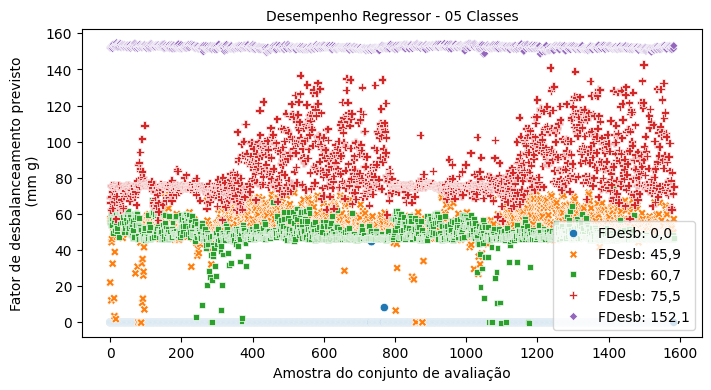

In [ ]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(8,4))
plt.title("Desempenho Regressor - 05 Classes", loc="center", fontsize=10)
plt.xlabel("Amostra do conjunto de avaliação")
ax = sn.scatterplot(data=df_predict)#, marker="+")
sn.move_legend(ax, "lower right")#, bbox_to_anchor=(1, 1))
plt.ylabel("Fator de desbalanceamento previsto\n (mm g)")
plt.show()